# Custom Models and Training with TensorFlow

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## A Quick Tour of TensorFlow

### What does TensorFlow offer?

* Its core is very similar to NumPy, but with **GPU support**.
 
* It supports **distributed computing** (across multiple devices and servers).
 
* It includes a kind of **just-in-time (JIT) compiler** that allows it to optimize computations for speed and memory usage. It works by extracting the computation graph from a Python function, then optimizing it (e.g., by pruning unused nodes), and finally running it efficiently (e.g., by automatically running independent operations in parallel).
 
* Computation graphs can be **exported to a portable format**, so you can train a TensorFlow model in one environment (e.g., using Python on Linux) and run it in another (e.g., using Java on an Android device).
 
* It implements **autodiff and provides some excellent optimizers**, such as RMSProp and Nadam, so you can easily minimize all sorts of loss functions.

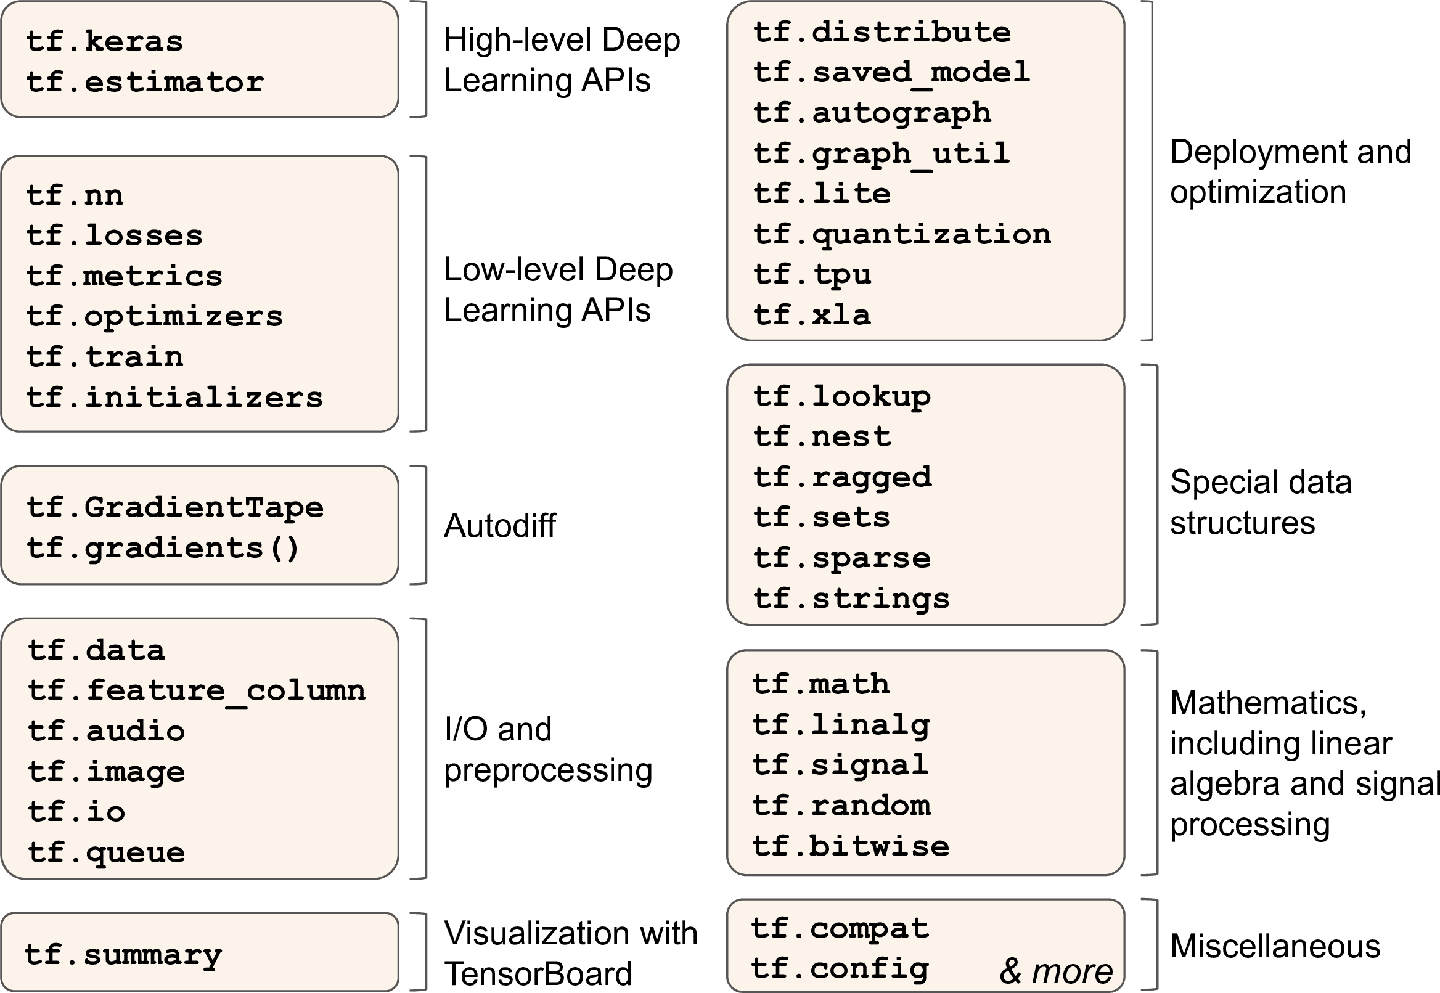




### TensorFlow’s architecture

* Most of the time your code will use the high-level APIs (especially tf.keras and tf.data)

* When you need more flexibility, you will use the lower-level Python API, handling tensors directly.


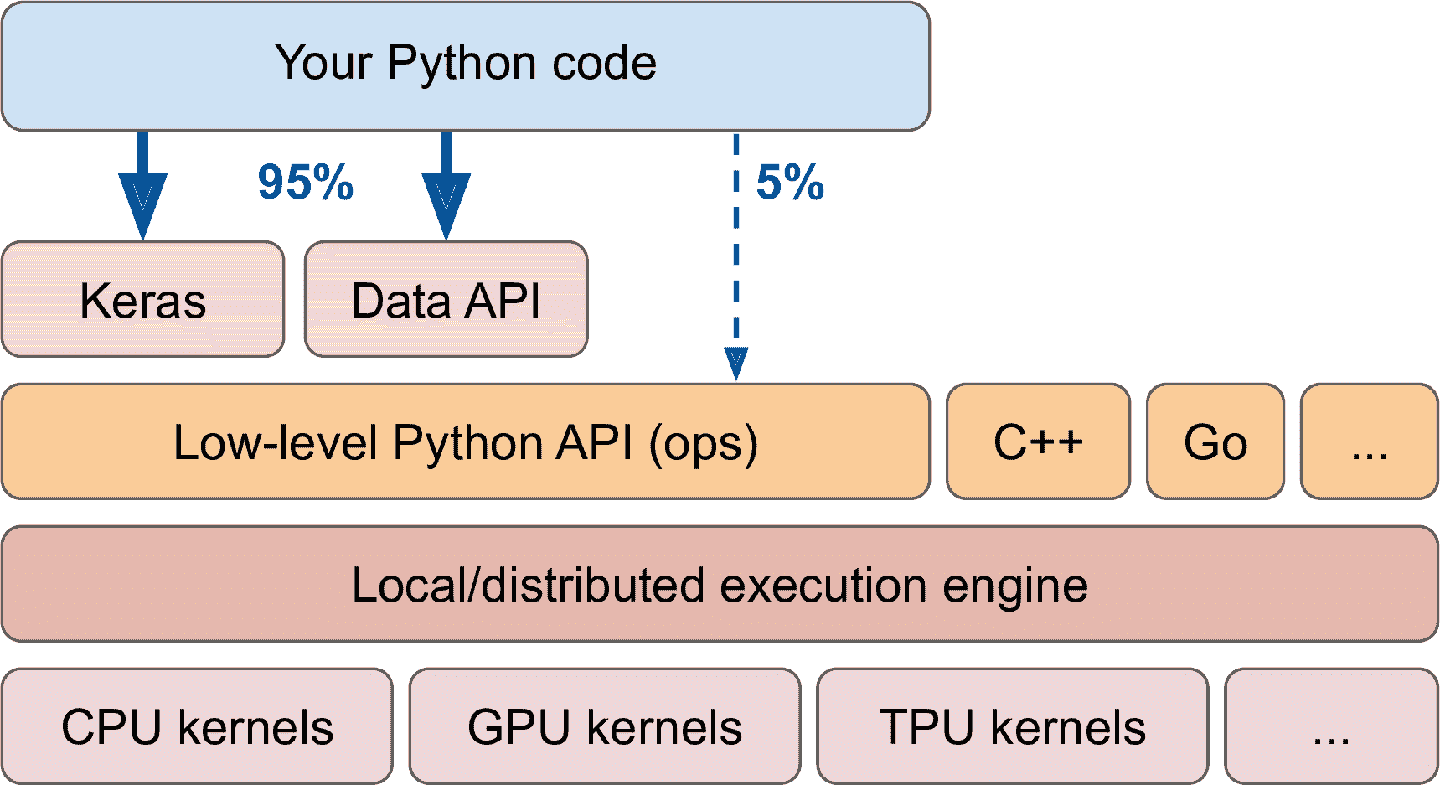

## Using TensorFlow like NumPy

### Tensors and operations


* A tensor is very similar to a NumPy ndarray: it is usually a **multidimensional array**, but it can also hold a scalar (a simple value, such as 42). 

* Use tensors to **create custom cost functions, custom metrics, custom layers, and more**


### Create a tensor with tf.constant()

In [2]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # a matrix with two rows and three columns of floats

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [3]:
tf.constant(42) # scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

### Just like an ndarray, a tf.Tensor has a shape and a data type (dtype)

In [4]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [5]:
t.shape

TensorShape([2, 3])

In [6]:
t.dtype

tf.float32

### Indexing works much like in NumPy

In [7]:
t[:, 1:] #start from the second column

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [8]:
t[..., 1, tf.newaxis] # if t is 2D, then t[..., 1] is equivalent to t[:, 1]. If 3D, then t[..., 1] is equivalent to t[:, :, 1].

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

### Ops

* Note that writing t + 10 is equivalent to calling tf.add(t, 10)

In [9]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [10]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

* The @ operator was added in Python 3.5, for matrix multiplication: it is equivalent to calling the tf.matmul() function.

*  tf.transpose() function does not do exactly the same thing as NumPy’s T attribute: 
    * in TensorFlow, a new tensor is created with its own copy of the transposed data, 
    * while in NumPy, t.T is just a transposed view on the same data. 


In [11]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

***Basic operations***

* ```tf.add(), tf.multiply(), tf.square(), tf.exp(), tf.sqrt()```, etc
* ```tf.reduce_mean(), tf.reduce_sum(), tf.reduce_max(), tf.math.log()``` are the equivalent of
```np.mean(), np.sum(), np.max(), np.log()```

    * GPU kernel (i.e., GPU implementation) uses a reduce algorithm that does not guarantee the order in which the elements are added. 
    * because 32-bit floats have limited precision, the result may change ever so slightly every time you call this operation. 

* ```tf.reshape(), tf.squeeze(), tf.tile()```

### Keras’ Low-Level API: Using `keras.backend`

* functions like ```square(), exp(), and sqrt()```

* portable to other Keras implementations

* only cover a subset of all functions available in TensorFlow

* so we will use the TensorFlow operations directly

In [12]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### Tensors( tf.constant( ) ) From/To NumPy

* create a tensor from a NumPy array, and vice versa

* apply TensorFlow operations to NumPy arrays and NumPy operations to tensors

In [13]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [14]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [15]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

***Notes:***

* NumPy uses 64-bit precision by default
* TensorFlow uses 32-bit -- enough for neural networks, plus it runs faster and uses less RAM

* So when you create a tensor from a NumPy array, make sure to set dtype=tf.float32

In [16]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [17]:
tf.square(tf.constant(a,  dtype=tf.float32))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 4., 16., 25.], dtype=float32)>

In [18]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### Conflicting Types and Type Conversions

* Type conversion is expensive

* TensorFlow does not perform any type conversions automatically
* it just raises an exception if you try to execute an operation on tensors with incompatible types
    * cannot add a float tensor and an integer tensor
    * cannot even add a 32-bit float and a 64-bit float

In [19]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [20]:
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


* use ```tf.cast()``` when you really need to convert types

In [21]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### String tensors

*  Tensors of ```tf.string``` represent byte strings, not Unicode strings

In [22]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

* Unicode string (e.g., a regular Python 3 string like "café"), then it will get encoded to UTF-8 automatically

In [23]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

* represent Unicode strings using tensors of type tf.int32, where each item represents a Unicode code point

In [24]:
u = tf.constant([ord(c) for c in "café"]) # a tensor of type tf.int32 holding Unicode code points, the length appears in the shape.
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

* The ```tf.strings``` package (with an s) contains ops for byte strings and Unicode strings (and to convert one into the other). 

In [25]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [26]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

### String arrays

In [27]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [28]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2])>

In [29]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>

In [30]:
print(r)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>


### Ragged tensors

*  A ragged tensor is a special kind of tensor that represents a list of arrays of different sizes

* a tensor with one or more ragged dimensions, meaning dimensions whose slices may have different lengths

* All the elements of the ragged tensor r are regular tensors

In [31]:
print(r[1])

tf.Tensor([ 67 111 102 102 101 101], shape=(6,), dtype=int32)


In [32]:
print(r[1:3])

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>


In [33]:
r2 = tf.ragged.constant([[65, 66], [], [67]])
print(tf.concat([r, r2], axis=0))

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>


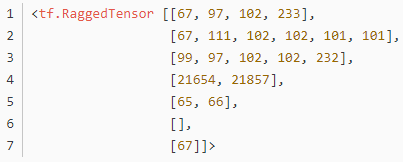

In [34]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71], [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


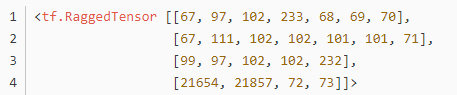

In [35]:
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

* If you call the ```to_tensor()``` method, it gets converted to a regular tensor, padding shorter tensors with zeros to get tensors of equal lengths

In [36]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]])>

### Sparse tensors

* Efficiently represent tensors containing mostly zeros. 
* The tf.sparse package contains operations for sparse tensors.
* specifying the indices and values of the nonzero elements and the tensor’s shape

In [37]:
st1 = tf.SparseTensor(indices=[[0, 3], [2, 4]],
                      values=[10, 20],
                      dense_shape=[3, 10])
print(st1)

SparseTensor(indices=tf.Tensor(
[[0 3]
 [2 4]], shape=(2, 2), dtype=int64), values=tf.Tensor([10 20], shape=(2,), dtype=int32), dense_shape=tf.Tensor([ 3 10], shape=(2,), dtype=int64))


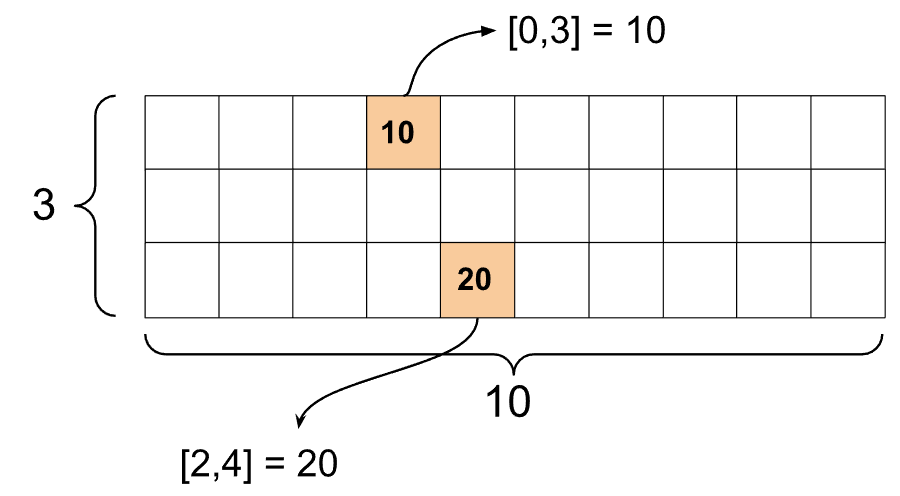

In [38]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])

In [39]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


* convert a sparse tensor to a dense tensor (i.e., a regular tensor) using ```tf.sparse.to_dense()```

In [40]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [41]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [42]:
s2 = s * 2.0
print(s2)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [43]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [44]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [45]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [46]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] = [0,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]


In [47]:
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### Sets

* TensorFlow supports sets of integers or strings (but not floats). 
* It represents them using regular tensors (or sparse tensors)


* compute the union of multiple pairs of sets simultaneously

In [48]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]])>

In [49]:
print(tf.sets.union(set1, set2))

SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [1 0]
 [1 1]
 [1 2]
 [1 3]], shape=(10, 2), dtype=int64), values=tf.Tensor([ 2  3  4  5  6  7  0  7  9 10], shape=(10,), dtype=int32), dense_shape=tf.Tensor([2 6], shape=(2,), dtype=int64))


In [50]:
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]])>

In [51]:
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]])>

### Variables

* The tf.Tensor values are immutable: you cannot modify them. 
* This means that we cannot use regular tensors to implement weights in a neural network, since they need to be tweaked by backpropagation
* What we need is a tf.Variable

In [52]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

In [53]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

* modify individual cells (or slices), by using the cell’s (or slice’s) assign() method

In [54]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [55]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

* direct item assignment will not work

In [56]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [57]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [58]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

***Notes***

* In practice you will rarely have to create variables manually, since Keras provides an add_weight() method that will take care of it for you, as we will see. 
* Moreover, model parameters will generally be updated directly by the optimizers, so you will rarely need to update variables manually.


### Tensor Arrays

* lists of tensors. 
* fixed size by default but can optionally be made dynamic. 
* All tensors they contain must have the same shape and data type

In [59]:
# you must assign the output back to the array

array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [60]:
array.read(1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

* stack all the items into a regular tensor by calling the stack() method

In [61]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [62]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

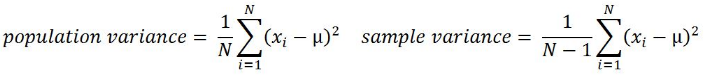

In [63]:
variance #population variance for each column

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>

# Customizing Models and Training Algorithms

## The most common use case: Custom loss function

* training set is a bit noisy
* removing or fixing the outliers, but that turns out to be insufficient; the dataset is still noisy
* The mean squared error might penalize large errors too much


* Use Huber loss
    * quadratic when the error is smaller than a threshold $δ$ (typically 1) 
    * linear when the error is larger than $δ$.

    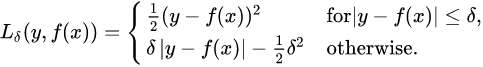

    * The linear part makes it less sensitive to outliers than the mean squared error
    * the quadratic part allows it to converge faster and be more precise than the mean absolute error


Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [64]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

***Steps***

* create a function that takes the labels and predictions as arguments, 
* use TensorFlow operations to compute every instance’s loss
* return a tensor containing one loss per instance, rather than returning the mean loss, so that Keras can apply class weights or sample weights when requested

In [65]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

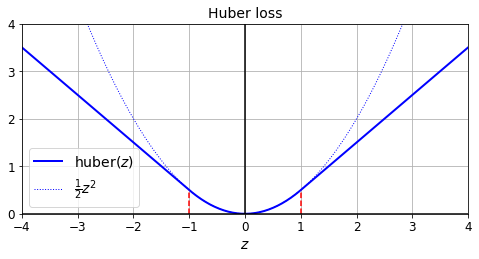

In [66]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [67]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

#### Use the custom loss function

In [68]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [69]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.6235 - mae: 0.9953 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2197 - mae: 0.5177 - val_loss: 0.2382 - val_mae: 0.5281


***Notes***

* For each batch during training, Keras will call the huber_fn() function to compute the loss and use it to perform a Gradient Descent step. 
* Moreover, it will keep track of the total loss since the beginning of the epoch, and it will display the mean loss.


## Saving/Loading Models with Custom Objects

* Keras saves the name of the function

In [70]:
model.save("my_model_with_a_custom_loss.h5")

* you’ll need to provide a dictionary that maps the function name to the actual function

* More generally, when you load a model containing custom objects, you need to map the names to the objects:

In [71]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [72]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2054 - mae: 0.4982 - val_loss: 0.2209 - val_mae: 0.5050
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1999 - mae: 0.4900 - val_loss: 0.2127 - val_mae: 0.4986


#### How to create a configurable huber function? 

* Solution: create a function that creates a configured loss function

In [73]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [74]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [75]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2226 - mae: 0.4892 - val_loss: 0.2540 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2184 - mae: 0.4844 - val_loss: 0.2372 - val_mae: 0.4879


* Unfortunately, when you save the model, the threshold will not be saved

In [76]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

***Notes***

* the name to use is "huber_fn", which is the name of the function you gave Keras, not the name of the function that created it

In [77]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [78]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2147 - mae: 0.4800 - val_loss: 0.2133 - val_mae: 0.4654
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2119 - mae: 0.4762 - val_loss: 0.1992 - val_mae: 0.4643


### Saving/Loading Models with Custom Loss Subclass

In [79]:
class HuberLoss(keras.losses.Loss):
    
    # The constructor accepts **kwargs and passes them to the parent constructor, which handles standard hyperparameters
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
        
    # The call() method takes the labels and predictions, computes all the instance losses, and returns them.
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    
    # The get_config() method returns a dictionary mapping each hyperparameter name to its value. 
    # It first calls the parent class’s get_config() method, then adds the new hyperparameters to this dictionary 
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [80]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

* You can then use any instance of this class when you compile the model

In [81]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [82]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.7095 - mae: 0.8863 - val_loss: 0.3378 - val_mae: 0.5485
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2416 - mae: 0.5083 - val_loss: 0.2660 - val_mae: 0.5089


### what does it save?

* When you save a model, Keras calls the loss instance’s get_config() method and saves the config as JSON in the HDF5 file. 
* When you load the model, it calls the from_config() class method on the HuberLoss class: this method is implemented by the base class (Loss) and creates an instance of the class, passing ```**config``` to the constructor.

In [83]:
model.save("my_model_with_a_custom_loss_class.h5")

In [84]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

In [85]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2286 - mae: 0.4970 - val_loss: 0.2120 - val_mae: 0.4723
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2216 - mae: 0.4904 - val_loss: 0.2045 - val_mae: 0.4725


In [86]:
model.loss.threshold

2.0

## Custom Activation Functions, Initializers, Regularizers, and Constraints

In [87]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

* custom activation function (equivalent to keras.activations.softplus() or tf.nn.softplus(),  tf.math.log( tf.exp(z)+1.0 ))

*  The activation function will be applied to the output of this Dense layer, and its result will be passed on to the next layer.

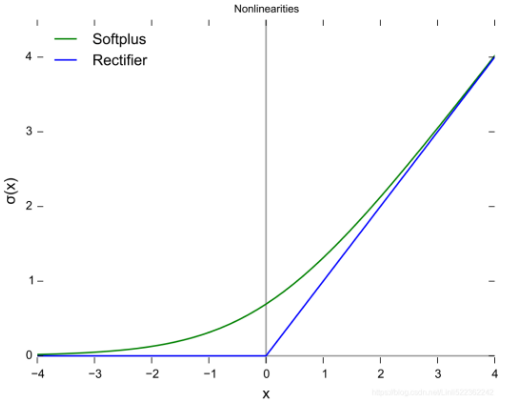

In [88]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

* a custom Glorot initializer (equivalent to ```keras.initializers.glorot_normal()```,Normal distribution with mean 0 and standard deviation 

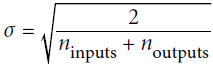

* The layer’s weights will be initialized using the value returned by the initializer. 

In [89]:
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

* a custom $ℓ_1$ regularizer (equivalent to ```keras.regularizers.l1(0.01)``` 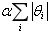

* At each training step the weights will be passed to the regularization function to compute the regularization loss, which will be added to the main loss to get the final loss used for training

In [90]:
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

* a custom constraint that ensures weights are all positive (equivalent to keras.constraints.nonneg() or tf.nn.relu())

* the constraint function will be called after each training step, and the layer’s weights will be replaced by the constrained weights.

In [91]:
def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [92]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [93]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [94]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [95]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [96]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [97]:
model.save("my_model_with_many_custom_parts.h5")

In [98]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

***hyperparameters of functions***

* If a function has hyperparameters that need to be saved along with the model, then you will want to subclass the appropriate class, such as ```keras.initializers.Initializer, keras.constraints.Constraint, keras.regularizers.Regularizer, or keras.layers.Layer``` (for any layer, including activation functions).

*  simple class for $ℓ_1$ regularization that saves its factor hyperparameter (this time we do not need to call the parent constructor or the get_config() method, as they are not defined by the parent class)

In [99]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [100]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [101]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [102]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [103]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [104]:
model.save("my_model_with_many_custom_parts.h5")

In [105]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

## Midterm Project

#### Kaggle Competition Practice: Digit Recognizer

You will build DNN to compete with worldwide teams.This is a small project so it will be an individual project. 

More details will be posted on canvas.

https://www.kaggle.com/c/digit-recognizer



